<a href="https://colab.research.google.com/github/EfanovNikita/knee_arthritis/blob/master/knee_arthritis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d hafiznouman786/annotated-dataset-for-knee-arthritis-detection

!unzip "annotated-dataset-for-knee-arthritis-detection.zip"

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/annotated-dataset-for-knee-arthritis-detection
License(s): CC0-1.0
 91% 53.0M/58.3M [00:00<00:00, 98.9MB/s]
100% 58.3M/58.3M [00:00<00:00, 94.0MB/s]
Archive:  annotated-dataset-for-knee-arthritis-detection.zip
  inflating: Training/0Normal/NormalG0 (1).png  
  inflating: Training/0Normal/NormalG0 (10).png  
  inflating: Training/0Normal/NormalG0 (100).png  
  inflating: Training/0Normal/NormalG0 (101).png  
  inflating: Training/0Normal/NormalG0 (102).png  
  inflating: Training/0Normal/NormalG0 (103).png  
  inflating: Training/0Normal/NormalG0 (104).png  
  inflating: Training/0Normal/NormalG0 (105).png  
  inflating: Training/0Normal/NormalG0 (106).png  
  inflating: Training/0Normal/NormalG0 (107).png  
  inflating: Training/0Normal/NormalG0 (108).png  
  inflating: Training/0Normal/NormalG0 (109).png  
  inflating: Training/0Normal/NormalG0 (11).png  
  inflating: Training/0Normal/NormalG0 (110).png  
  inflating: Trainin

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    './Training',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset='training',
    label_mode='categorical',
    seed=124
)
val_data = tf.keras.utils.image_dataset_from_directory(
    './Training',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset='validation',
    label_mode='categorical',
    seed=124
)
print(train_data)
print(val_data)
print(train_data.class_names)
class_names = train_data.class_names

Found 1650 files belonging to 5 classes.
Using 1320 files for training.
Found 1650 files belonging to 5 classes.
Using 330 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']


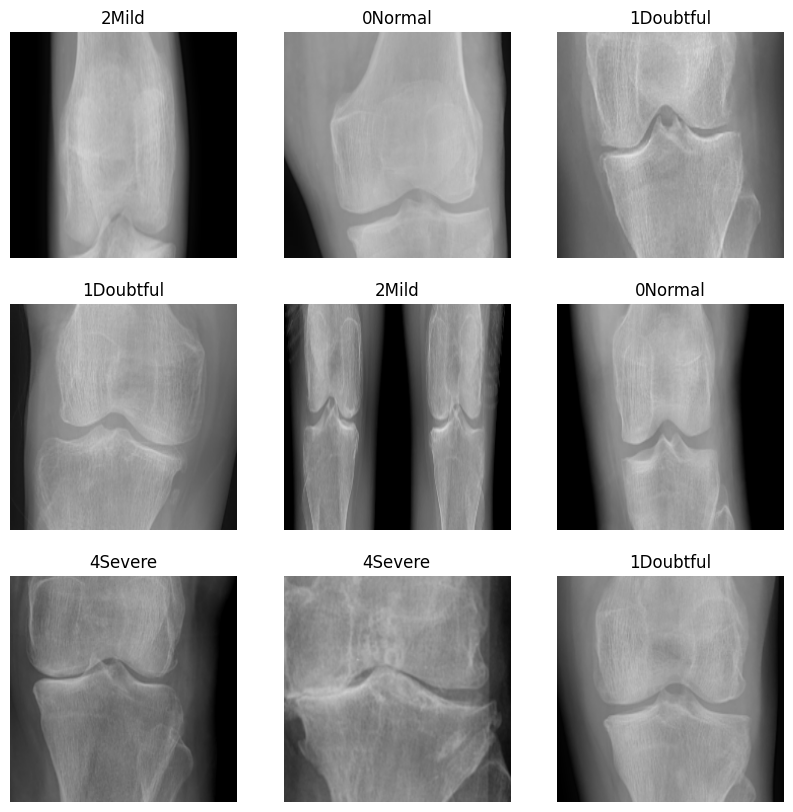

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[list(labels[i]).index(1)])
    plt.axis("off")

In [ ]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callback1 = tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    mode='max', min_delta=0.001,
                    patience = 10)

In [ ]:
epochs=100
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback1]
)

Epoch 1/100
42/42 [==============================] - 10s 108ms/step - loss: 1.8380 - accuracy: 0.3174 - val_loss: 1.5301 - val_accuracy: 0.3152
Epoch 2/100
42/42 [==============================] - 4s 82ms/step - loss: 1.4448 - accuracy: 0.3644 - val_loss: 1.4605 - val_accuracy: 0.3667
Epoch 3/100
42/42 [==============================] - 4s 85ms/step - loss: 1.4120 - accuracy: 0.3742 - val_loss: 1.4435 - val_accuracy: 0.3212
Epoch 4/100
42/42 [==============================] - 5s 100ms/step - loss: 1.3289 - accuracy: 0.4265 - val_loss: 1.9900 - val_accuracy: 0.2303
Epoch 5/100
42/42 [==============================] - 4s 85ms/step - loss: 1.2944 - accuracy: 0.4545 - val_loss: 1.4131 - val_accuracy: 0.3848
Epoch 6/100
42/42 [==============================] - 4s 84ms/step - loss: 1.1641 - accuracy: 0.5121 - val_loss: 1.4052 - val_accuracy: 0.4152
Epoch 7/100
42/42 [==============================] - 5s 118ms/step - loss: 1.0256 - accuracy: 0.5833 - val_loss: 1.3754 - val_accuracy: 0.4667
Ep

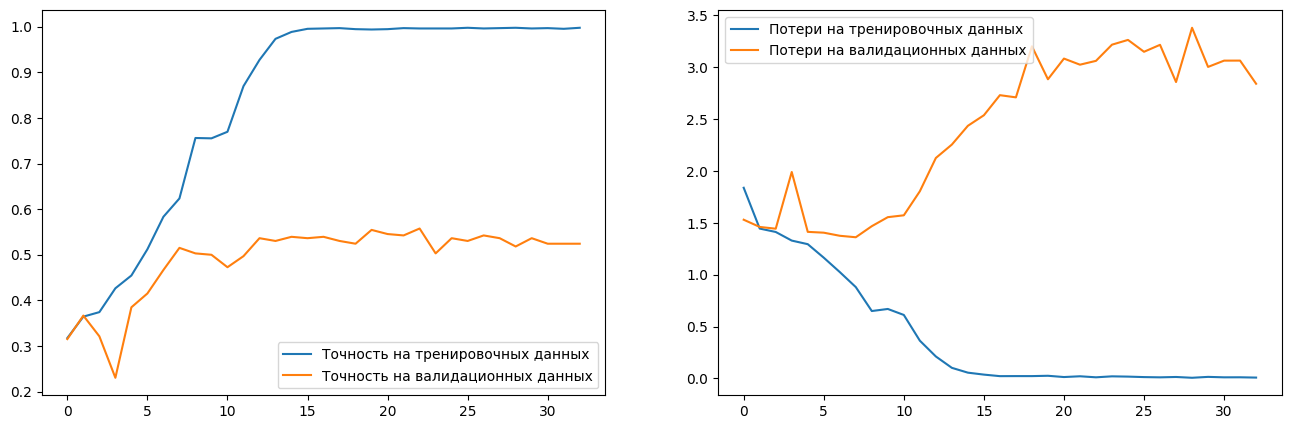

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = history.epoch

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на тренировочных данных')
plt.plot(epochs_range, val_acc, label='Точность на валидационных данных')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на тренировочных данных')
plt.plot(epochs_range, val_loss, label='Потери на валидационных данных')
plt.legend(loc='upper left')

На этих графиках видно, что примерно после 10 эпохи точность на валидационных данных перестает расти, а потери только возрастают. Это может свидетельствовать о переобучении модели. Попробуем исправить это добавив в модель слой Dropout, который будет случайным образом "отключать" некоторые нейроны. Также добавим один слой BatchNormalization, чтобы нормализировать выходные данные внутреннего слоя.

In [ ]:
model_2 = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

In [ ]:
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs=100
history = model_2.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback1]
)

Epoch 1/100
42/42 [==============================] - 8s 100ms/step - loss: 4.4298 - accuracy: 0.2803 - val_loss: 1.6081 - val_accuracy: 0.2970
Epoch 2/100
42/42 [==============================] - 4s 95ms/step - loss: 1.4862 - accuracy: 0.3470 - val_loss: 1.6019 - val_accuracy: 0.2970
Epoch 3/100
42/42 [==============================] - 5s 108ms/step - loss: 1.4019 - accuracy: 0.3977 - val_loss: 1.6018 - val_accuracy: 0.2636
Epoch 4/100
42/42 [==============================] - 4s 96ms/step - loss: 1.3184 - accuracy: 0.4280 - val_loss: 1.6017 - val_accuracy: 0.2636
Epoch 5/100
42/42 [==============================] - 5s 111ms/step - loss: 1.2887 - accuracy: 0.4424 - val_loss: 1.5924 - val_accuracy: 0.2636
Epoch 6/100
42/42 [==============================] - 4s 96ms/step - loss: 1.2218 - accuracy: 0.4932 - val_loss: 1.5865 - val_accuracy: 0.2636
Epoch 7/100
42/42 [==============================] - 4s 97ms/step - loss: 1.0904 - accuracy: 0.5417 - val_loss: 1.5726 - val_accuracy: 0.2636
Epo

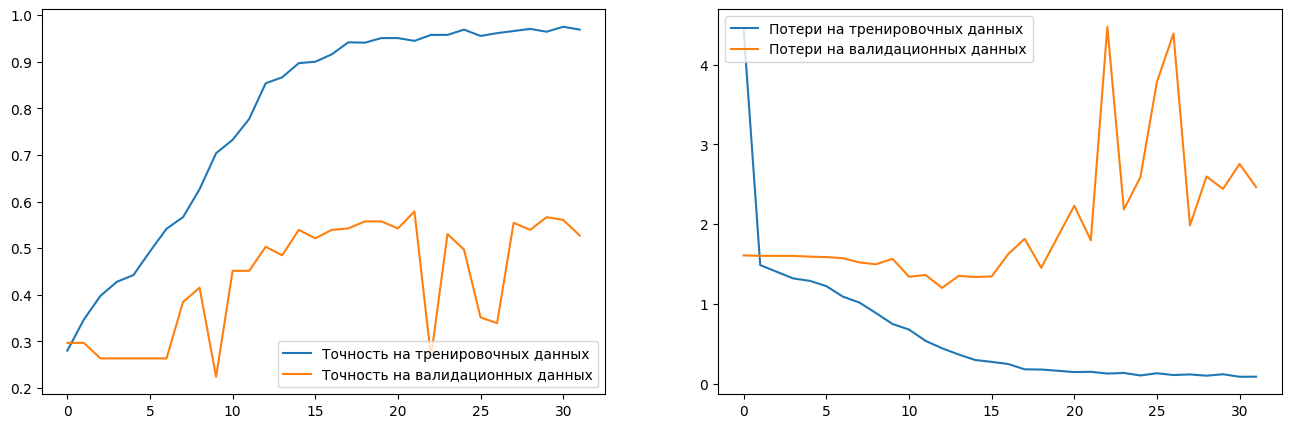

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на тренировочных данных')
plt.plot(epochs_range, val_acc, label='Точность на валидационных данных')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на тренировочных данных')
plt.plot(epochs_range, val_loss, label='Потери на валидационных данных')
plt.legend(loc='upper left')

По данным этих графиков можно сделать вывод. что ситуация не сильно изменилась. Максимальная валидационная точность все также находиться около 50%. Попробуем добавить несколько слоев для аугментации данных и еще по одному слою Dropout и BatchNormalization.

In [ ]:
model_3 = Sequential([
    layers.RandomFlip('horizontal', input_shape=(224, 224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.Rescaling(1./255),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax'),
])

In [ ]:
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs=100
history = model_3.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback1]
)

Epoch 1/100
42/42 [==============================] - 9s 108ms/step - loss: 20.1954 - accuracy: 0.2629 - val_loss: 8.8902 - val_accuracy: 0.1636
Epoch 2/100
42/42 [==============================] - 5s 117ms/step - loss: 4.3112 - accuracy: 0.3182 - val_loss: 12.0601 - val_accuracy: 0.2727
Epoch 3/100
42/42 [==============================] - 5s 103ms/step - loss: 1.6940 - accuracy: 0.3083 - val_loss: 19.5843 - val_accuracy: 0.2636
Epoch 4/100
42/42 [==============================] - 5s 118ms/step - loss: 1.5626 - accuracy: 0.2970 - val_loss: 22.7458 - val_accuracy: 0.2636
Epoch 5/100
42/42 [==============================] - 5s 106ms/step - loss: 1.5413 - accuracy: 0.2947 - val_loss: 22.4795 - val_accuracy: 0.2636
Epoch 6/100
42/42 [==============================] - 6s 122ms/step - loss: 1.5402 - accuracy: 0.2955 - val_loss: 19.7594 - val_accuracy: 0.2636
Epoch 7/100
42/42 [==============================] - 5s 102ms/step - loss: 1.5304 - accuracy: 0.3053 - val_loss: 14.3347 - val_accuracy:

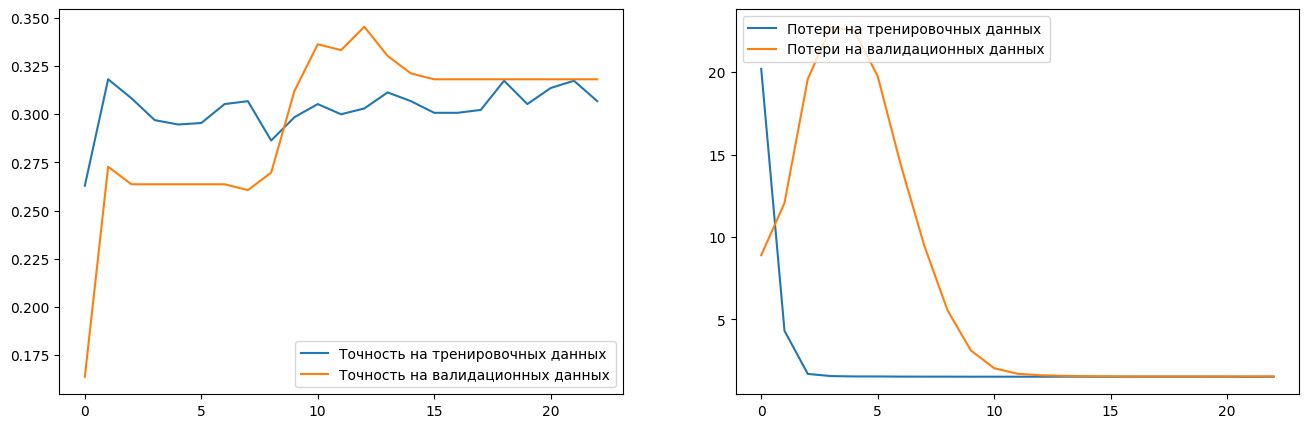

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = history.epoch

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на тренировочных данных')
plt.plot(epochs_range, val_acc, label='Точность на валидационных данных')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на тренировочных данных')
plt.plot(epochs_range, val_loss, label='Потери на валидационных данных')
plt.legend(loc='upper left')

Как мы видим на этих графиках, наша модель не только не улучшилась, но стала хуже. Теперь точность валидационных данных не выросла больше 40%, а сама модель перестает обучаться даже на тренировочных данных. Попробуем убрать слои аугментации и добавить слой для первичной обработки данных. Этот слой превращает цветное rgb изображение в черно-белое.

In [ ]:
model_4 = Sequential([
    layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),
    layers.Rescaling(1./255, input_shape=(224, 224, 1)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax'),
])

In [ ]:
model_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs=100
history = model_4.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback1]
)

Epoch 1/100
42/42 [==============================] - 7s 115ms/step - loss: 5.2160 - accuracy: 0.2583 - val_loss: 1.6088 - val_accuracy: 0.2636
Epoch 2/100
42/42 [==============================] - 5s 102ms/step - loss: 1.4926 - accuracy: 0.3303 - val_loss: 1.6055 - val_accuracy: 0.2636
Epoch 3/100
42/42 [==============================] - 4s 93ms/step - loss: 1.4329 - accuracy: 0.3402 - val_loss: 1.6031 - val_accuracy: 0.2636
Epoch 4/100
42/42 [==============================] - 5s 108ms/step - loss: 1.3599 - accuracy: 0.4114 - val_loss: 1.6044 - val_accuracy: 0.2727
Epoch 5/100
42/42 [==============================] - 4s 95ms/step - loss: 1.2928 - accuracy: 0.4598 - val_loss: 1.6047 - val_accuracy: 0.2030
Epoch 6/100
42/42 [==============================] - 5s 109ms/step - loss: 1.2385 - accuracy: 0.4591 - val_loss: 1.6026 - val_accuracy: 0.1758
Epoch 7/100
42/42 [==============================] - 5s 97ms/step - loss: 1.1228 - accuracy: 0.5402 - val_loss: 1.6087 - val_accuracy: 0.1818
Ep

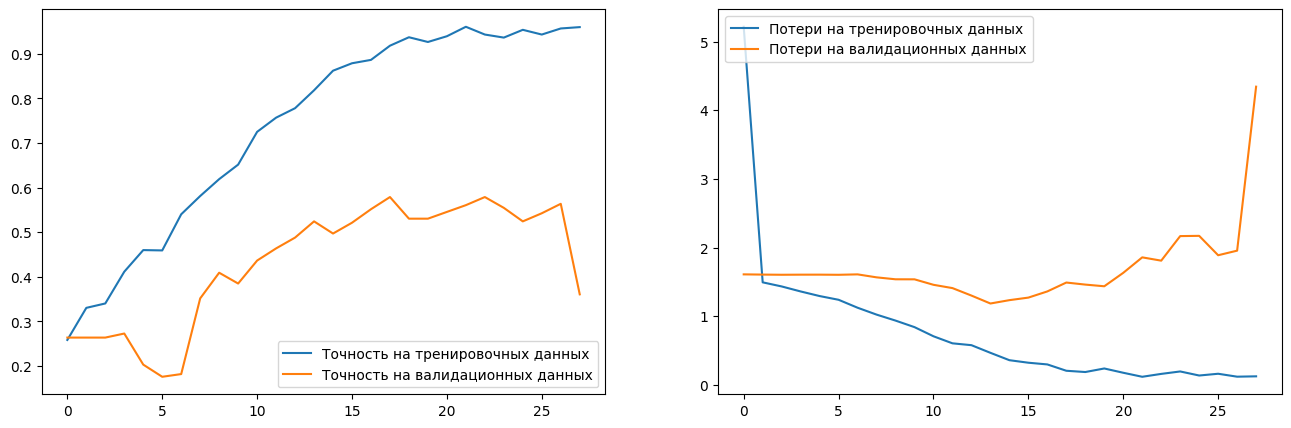

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = history.epoch

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на тренировочных данных')
plt.plot(epochs_range, val_acc, label='Точность на валидационных данных')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на тренировочных данных')
plt.plot(epochs_range, val_loss, label='Потери на валидационных данных')
plt.legend(loc='upper left')

Как видно на графиках, ситация стала лучше по сравнению с предыдущим результатом. Но по результатам точности на валидационных данных эта модель не превосходит первые две модели.